# Libs and pre-definitions

In [1]:
import matplotlib.pyplot as plt
import torch
import botorch
import gpytorch
from scipy import stats

In [2]:
dev = torch.device('cuda')

In [3]:
torch.manual_seed(42);
torch.set_default_dtype(torch.float64)

# Functions

$$ F(x,\omega,\gamma) = \prod_{i=1}^{N} sin(\omega X_i)tanh(\gamma X_i^2) + \epsilon, \quad \epsilon \sim \mathcal{N}(0,\sigma)$$

In [4]:
def olivers_fn(X:torch.tensor,w:float = 5,gamma:float = 1,noise = False):
    y = torch.prod(torch.sin(w*X)*(1-torch.tanh(gamma*X.pow(2))),-1,keepdims=True)
    if noise:
        y += torch.randn_like(y)*noise
    return y

In [5]:
NOISE = 0.1

# Plot

In [6]:

N = 25
x = torch.linspace(-5,5,10000).unsqueeze(-1)
x_sample = torch.randn((N,1))#np.random.uniform(low=-4, high=4, size=(25,1)) #

y_true = olivers_fn(x,noise = 0)
y_sample = olivers_fn(x_sample,noise = NOISE)

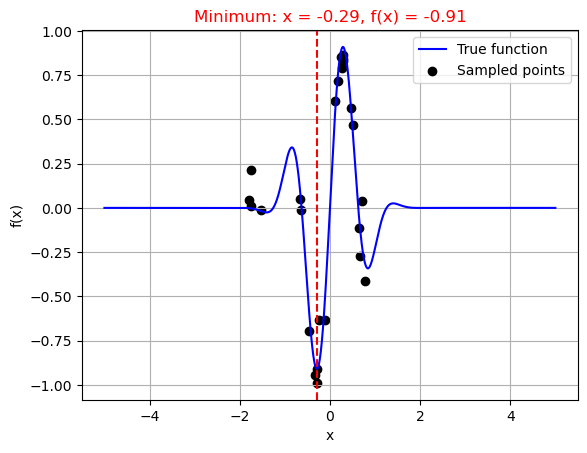

In [7]:
plt.plot(x,y_true, color = 'blue', label = 'True function')
plt.scatter(x_sample,y_sample, color = 'black', label = 'Sampled points')
true_minimal = (x[y_true.argmin()].item(),y_true.min())
plt.axvline(x[y_true.argmin()],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

# Gaussian Process

In [8]:
gpr = botorch.models.SingleTaskGP(x_sample,y_sample)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(gpr.likelihood, gpr)
botorch.fit.fit_gpytorch_mll(mll)
acquisition = botorch.acquisition.ExpectedImprovement(gpr, y_sample.min(), maximize=False)

/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.6177]), mean = tensor([0.0498])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


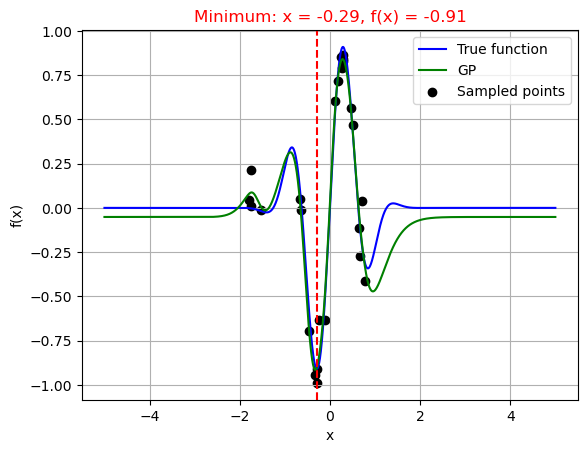

In [9]:
plt.plot(x,y_true, color = 'blue', label = 'True function')
plt.plot(x,gpr(x).loc.detach().numpy(),color = 'green', label = 'GP')
plt.scatter(x_sample,y_sample, color = 'black', label = 'Sampled points')
true_minimal = (x[y_true.argmin()].item(),y_true.min())
plt.axvline(x[y_true.argmin()],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


In [10]:
with torch.no_grad():
    # Make predictions
    observed_pred = gpr.posterior(x)

# Extract mean and standard deviation
y_pred = observed_pred.mean
std = observed_pred.mvn.covariance_matrix.diag().sqrt()

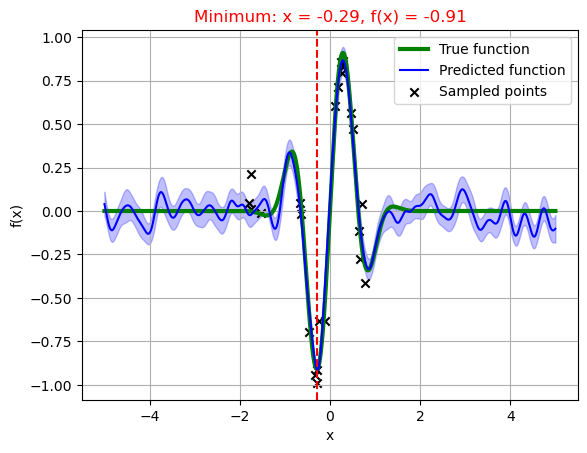

In [16]:
plt.plot(x,y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x,y_pred, color = 'blue', label = 'Predicted function')
plt.fill_between(x.flatten(),y_pred.flatten()-std,y_pred.flatten()+std, alpha = 0.25, color = 'blue')
plt.scatter(x_sample,y_sample, color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[torch.argmin(y_true)].item(),y_true.min())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


# Optimizer

In [12]:
class BayesianOptimizer():
    
    def __init__(self,true_model,surrogate_model_class = botorch.models.SingleTaskGP,
                 acquisition_fn = botorch.acquisition.ExpectedImprovement,D:tuple = (),initial_x = torch.tensor([[0]])):
        
        self.true_model = true_model
        self.surrogate_model_class = surrogate_model_class
        self.acquisition_fn = acquisition_fn
        if len(D)==0 : self.D = (initial_x,true_model(initial_x))
        elif D[0].size ==0: self.D = (initial_x,true_model(initial_x))
        else: self.D = D
        self.model = self.surrogate_model_class(*self.D)
        self.i = 1
        
    def fit_surrogate_model(self):
        self.model = self.surrogate_model_class(*self.D)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        botorch.fit.fit_gpytorch_mll(mll)
    
    def get_new_x(self,x_range = (-5.,5.)):
        acquisition = self.acquisition_fn(self.model, self.D[1].min(), maximize=False)
        return botorch.optim.optimize.optimize_acqf(acquisition, torch.as_tensor(x_range).unsqueeze(-1), 1, 5,raw_samples=20)[0]
    def update_D(self,x,y):
        x,y = x.reshape(-1,self.D[0].shape[1]), y.reshape(-1,self.D[1].shape[1])
        self.D = (torch.cat([self.D[0], x]),torch.cat([self.D[1], y]))
        
    def run_optimization(self,x_range_suboptimization = (-5.,5.), **convergence_params):
        while not self.stopping_criterion(**convergence_params):
            model = self.fit_surrogate_model()
            x = self.get_new_x(x_range_suboptimization)
            y = self.true_model(x)
            self.update_D(x,y)
            self.i += 1
        idx = self.D[1].argmax()
        return self.D[0][idx],self.D[1][idx]
    
    def stopping_criterion(self,**convergence_params):
        return self.i > convergence_params['max_iter']

## Random initial points

In [13]:
N_initial_points = 20
initial_x = 10*(torch.rand(N_initial_points,1)-0.5)
gpr = botorch.models.SingleTaskGP
BayesOpt = BayesianOptimizer(lambda x: olivers_fn(x,noise=NOISE),gpr,initial_x = initial_x)

/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1221]), mean = tensor([-0.0102])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


In [14]:
MAX_ITER = 100
x_opt, y_opt = BayesOpt.run_optimization(x_range_suboptimization = (-5.,5.), max_iter = MAX_ITER)
print(x_opt,y_opt)

/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1639]), mean = tensor([-0.0348])). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/disk/users/lprate/miniconda3/lib/python3.12/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.2201]), mean = tensor([-0.0670])). Please consider sc

tensor([0.2210]) tensor([0.8867])


### Plot

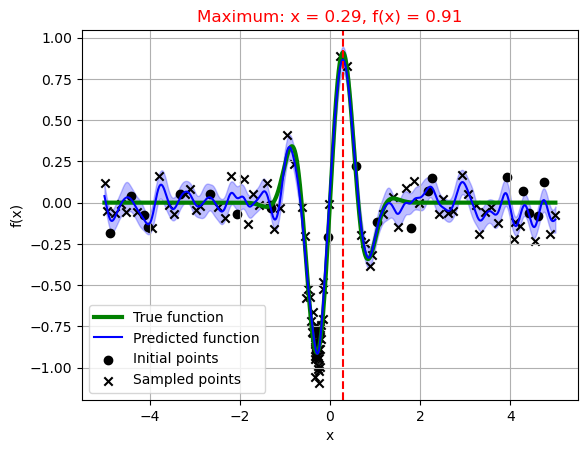

In [15]:
x = torch.linspace(-5,5,10000).unsqueeze(-1)
y_true = olivers_fn(x,noise = 0)

with torch.no_grad():
    gpr = BayesOpt.model
    gpr.eval()
    observed_pred = gpr.posterior(x)
    y_pred = observed_pred.mean.flatten()
    std = observed_pred.mvn.covariance_matrix.diag().sqrt()


#plt.plot(x,BayesOpt.calc_expected_improvement(x), color = 'black', label = 'Expected improvement')
plt.plot(x,y_true, color = 'green', label = 'True function',linewidth = 3)
plt.plot(x,y_pred, color = 'blue', label = 'Predicted function')
plt.fill_between(x.flatten(),y_pred-std,y_pred+std, alpha = 0.25, color = 'blue')
plt.scatter(BayesOpt.D[0][:N_initial_points],BayesOpt.D[1][:N_initial_points], color = 'black', label = 'Initial points', marker = 'o')
plt.scatter(BayesOpt.D[0][N_initial_points:],BayesOpt.D[1][N_initial_points:], color = 'black', label = 'Sampled points', marker = 'x')
true_minimal = (x[torch.argmax(y_true)].item(),y_true.max())
plt.axvline(true_minimal[0],color = 'red', linestyle = '--')#,label = f'Minimum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}')
plt.title(f'Maximum: x = {true_minimal[0]:.2f}, f(x) = {true_minimal[1]:.2f}', color = 'red')
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()